# Before getting started

need to first extract all the test smiles strings and the explicit ligand posing for aligning and searching

## Align Proteins to Reference Structures

- sars align to sars reference  
- sars align to mers reference (because of the conserved binding site)  
- mers align to mers reference  







In [5]:
import pymol, glob, os
from rdkit import Chem
from tqdm import tqdm
from Bio import PDB

key_residue_sars = [41, 140, 141, 142, 143, 144, 145, 163, 164, 165, 166, 172, 187, 188, 189]
key_residue_mers = [41, 143, 144, 145, 146, 147, 148, 166, 167, 168, 169, 175, 190, 191, 192]

# pymol alignment based on key residues and output transformation matrix
sars_ref = "../ALIGNMENT_REFERENCES/SARS-CoV-2-Mpro/reference_structure/complex.pdb"
mers_ref = "../ALIGNMENT_REFERENCES/MERS-CoV-Mpro/reference_structure/complex.pdb"

import pymol, os, pickle
from tqdm import tqdm
# alignment based on chain A
def check_for_unk_chain(complex_path):
    """
    Returns the chain ID ('A' or 'B') whose His41 is closest to ligand atom 0
    
    Args:
        complex_path: Path to PDB complex with UNK ligand
    Returns:
        str: Chain ID ('A' or 'B') that's closest to ligand
    """
    # Load structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('complex', complex_path)
    
    # Get His41 from both chains
    his41_A = structure[0]['A'][41]  # Model 0, Chain A, Residue 41
    his41_B = structure[0]['B'][41]  # Model 0, Chain B, Residue 41
    
    # Get first atom of UNK ligand
    for chain in structure[0]:
        for residue in chain:
            if residue.get_resname() == 'UNK':
                lig_atom0 = list(residue.get_atoms())[0]
                break
    
    # Calculate distances from ligand atom 0 to His41 CA of each chain
    dist_A = lig_atom0 - his41_A['CA']
    dist_B = lig_atom0 - his41_B['CA']
    
    # Return chain ID with smallest distance
    return 'A' if dist_A < dist_B else 'B'

def map_pdb_coordinates_to_sdf(pdb_path, sdf_path):
    mol_sdf = Chem.SDMolSupplier(sdf_path, removeHs=False)[0]
    mol_pdb = Chem.MolFromPDBFile(pdb_path, removeHs=False)
    # get the coordinates of the atoms
    pdb_coords = mol_pdb.GetConformer().GetPositions()
    sdf_conf = mol_sdf.GetConformer()

    for i, coords in enumerate(pdb_coords):
        sdf_conf.SetAtomPosition(i, coords)

    writer = Chem.SDWriter(pdb_path.replace(".pdb", "_final.sdf"))
    writer.write(mol_sdf)
    writer.close()
    return pdb_path.replace(".pdb", "_final.sdf")

def align_pred(protein_path, self_type, ref_type):
    pymol.cmd.delete("all")
    if ref_type == 'MERS-CoV Mpro':
        ref_path = mers_ref
    elif ref_type == "SARS-CoV-2 Mpro":
        ref_path = sars_ref
    else:
        raise Exception
    chain = check_for_unk_chain(protein_path)
    pymol.cmd.load(protein_path, "mobile")
    pymol.cmd.load(ref_path, "reference")
    pymol.cmd.align(
        f"chain {chain} and mobile and name CA and resi {'+'.join(map(str, key_residue_sars if self_type=='SARS-CoV-2 Mpro' else key_residue_mers))}",
        f"chain A and reference and name CA and resi {'+'.join(map(str, key_residue_sars if ref_type=='SARS-CoV-2 Mpro' else key_residue_mers))}",
        transform=1,
        object="alignment_matrix"
    )
    ret_path = os.path.join(os.path.dirname(protein_path), "protein_aligned.pdb")
    ligand_aligned = os.path.join(os.path.dirname(protein_path), "ligand_aligned.pdb")
    pymol.cmd.save(ret_path, f"mobile and chain {chain}")
    pymol.cmd.save(ligand_aligned, f"mobile and resname UNK")
    
    map_pdb_coordinates_to_sdf(ligand_aligned, os.path.join(os.path.dirname(protein_path), "ligand.sdf"))
    return ret_path

def align_pred_mers(protein_path):
    pymol.cmd.delete("all")
    chain = check_for_unk_chain(protein_path)
    pymol.cmd.load(protein_path, "mobile")
    pymol.cmd.load(mers_ref, "reference")
    pymol.cmd.align(
        f"chain {chain} and mobile and name CA and resi {'+'.join(map(str, key_residue_sars))}",
        f"chain A and reference and name CA and resi {'+'.join(map(str, key_residue_mers))}",
        transform=1,
        object="alignment_matrix"
    )
    ret_path = os.path.join(os.path.dirname(protein_path), "protein_aligned_mers.pdb")
    ligand_aligned = os.path.join(os.path.dirname(protein_path), "ligand_aligned_mers.pdb")
    pymol.cmd.save(ret_path, f"mobile and chain {chain}")
    pymol.cmd.save(ligand_aligned, f"mobile and resname UNK")
    
    map_pdb_coordinates_to_sdf(ligand_aligned, os.path.join(os.path.dirname(protein_path), "ligand.sdf"))
    return ret_path

In [ ]:
sars2_protein_folder = glob.glob("../ligand-posing/SARS-CoV-2*")
mers_protein_folder = glob.glob("../ligand-posing-mers/*")

for folder in tqdm(sars2_protein_folder):
    align_pred(os.path.join(folder, "complex.pdb"), "SARS-CoV-2 Mpro")
for folder in tqdm(mers_protein_folder):
    try:
        align_pred(glob.glob(os.path.join(folder, "*.pdb"))[0], "MERS-CoV Mpro")
    except:
        print(f"Error aligning {folder}")


In [6]:
sars2_protein_folder = glob.glob("../ligand-posing/SARS-CoV-2*")

for folder in tqdm(sars2_protein_folder):
    align_pred_mers(os.path.join(folder, "complex.pdb"))

100%|██████████| 770/770 [09:36<00:00,  1.34it/s]


## Cluster Proteins

- cluster on experiemental data
- cluster on mcsce results (https://www.sciencedirect.com/science/article/pii/S0969212614003566)

In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Bio import PDB
import glob, os, shutil
from tqdm import tqdm

# Function to extract side chain atom coordinates
def extract_side_chain_features(protein_files, key_residues):
    features = []
    parser = PDB.PDBParser(QUIET=True)
    for file in tqdm(protein_files):
        structure = parser.get_structure('protein', file)
        model = structure[0]  # Assuming single model
        feature_vector = []
        for chain in model:
            for residue in chain:
                if residue.id[1] in key_residues:
                    for atom in residue: # Exclude backbone atoms
                        if not atom.get_name().startswith("H"):
                            feature_vector.extend(atom.get_coord())
        features.append(feature_vector)
    return features

# Assuming 'features' is your feature matrix
def perform_dbscan(features, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features)
    return labels

# Visualize clusters using PCA
def visualize_dbscan_clusters(features, labels):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            label = 'Noise'
        else:
            label = f'Cluster {k}'

        class_member_mask = (labels == k)
        xy = reduced_features[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6, label=label)

    plt.title('DBSCAN Clustering Visualization with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.show()

In [2]:
# H39, H164, E167 [Key Trio - MERS]
# H41, H163, E166 [Key Trio - SARS]

key_residue_sars = [41, 140, 141, 142, 143, 144, 145, 163, 164, 165, 166, 172, 187, 188, 189]
key_residue_mers = [41, 143, 144, 145, 146, 147, 148, 166, 167, 168, 169, 175, 190, 191, 192]

In [13]:
mers_protein_files = glob.glob("../ligand-posing-mers/*/protein_aligned.pdb") # List of protein file paths
mers_features = extract_side_chain_features(mers_protein_files, key_residue_mers)

counts = np.unique([len(f) for f in mers_features], return_counts=True)
most_common_count = counts[0][np.argmax(counts[1])]
print(most_common_count)

all_index_to_remove = []
for i, f in enumerate(mers_features):
    if len(f) != most_common_count:
        all_index_to_remove.append(i)

mers_protein_files = [mers_protein_files[i] for i in range(len(mers_protein_files)) if i not in all_index_to_remove]
mers_features = np.array([mers_features[i] for i in range(len(mers_features)) if i not in all_index_to_remove])

100%|██████████| 34/34 [00:01<00:00, 26.06it/s]

357


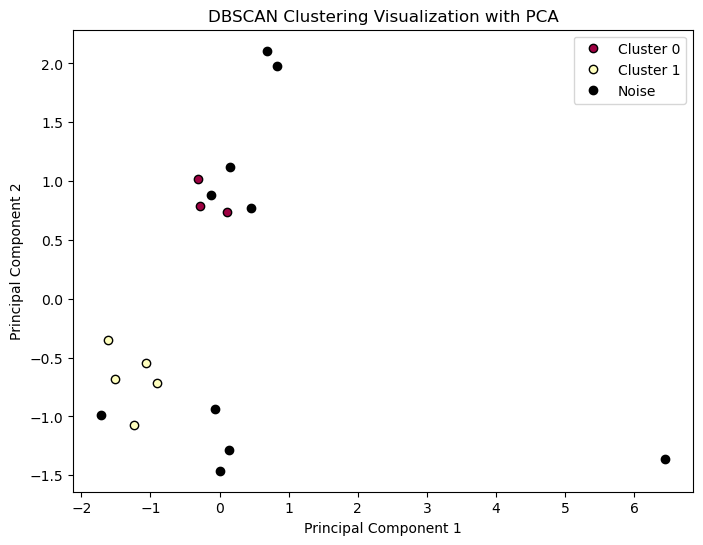

In [17]:
mers_labels = perform_dbscan(mers_features, eps=2, min_samples=3)
visualize_dbscan_clusters(mers_features, mers_labels)

In [5]:
rep_proteins = {}
for i in range(len(labels)):
    if labels[i] == -1:
        rep_proteins['noise'] = protein_files[i]
    else:
        rep_proteins[labels[i]] = protein_files[i]
rep_proteins

for k,v in rep_proteins.items():
    if k != 'noise':
        shutil.copy(v, f"../polaris-proteins/exp/mers-rep-{k+1}.pdb")

In [8]:
sars_protein_files = glob.glob("../ligand-posing/SARS-CoV-2*/protein_aligned.pdb") # List of protein file paths
sars_features = extract_side_chain_features(sars_protein_files, key_residue_sars)

counts = np.unique([len(f) for f in sars_features], return_counts=True)
most_common_count = counts[0][np.argmax(counts[1])]
print(most_common_count)

all_index_to_remove = []
for i, f in enumerate(sars_features):
    if len(f) != most_common_count:
        all_index_to_remove.append(i)

sars_protein_files = [sars_protein_files[i] for i in range(len(sars_protein_files)) if i not in all_index_to_remove]
sars_features = np.array([sars_features[i] for i in range(len(sars_features)) if i not in all_index_to_remove])

  0%|          | 0/770 [00:00<?, ?it/s]

100%|██████████| 770/770 [00:41<00:00, 18.49it/s]

384


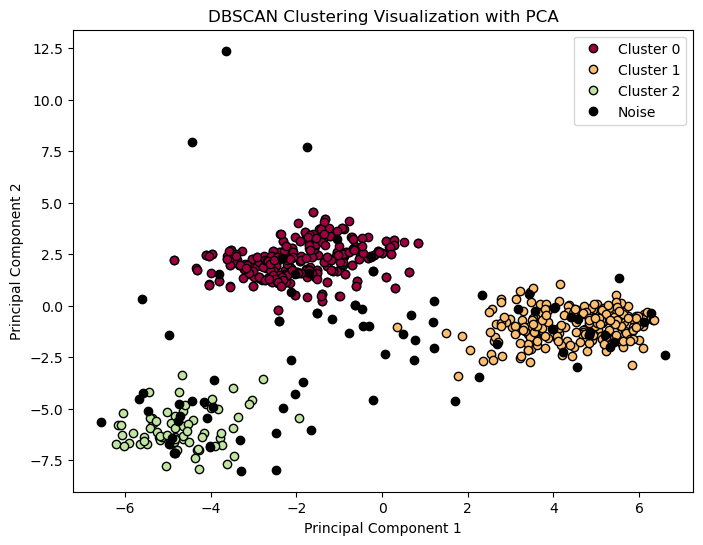

In [11]:
sars_labels = perform_dbscan(sars_features, eps=5, min_samples=10)
visualize_dbscan_clusters(sars_features, sars_labels)

In [47]:
sars_rep_proteins = {}
for i in range(len(sars_labels)):
    if sars_labels[i] == -1:
        sars_rep_proteins['noise'] = sars_protein_files[i]
    else:
        sars_rep_proteins[sars_labels[i]] = sars_protein_files[i]

for k,v in sars_rep_proteins.items():
    if k != 'noise':
        shutil.copy(v, f"../polaris-proteins/exp/sars-rep-{k+1}.pdb")


## Clean and Fix Proteins for docking

In [18]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile

def fix_protein(input_pdb, output_pdb, keep_water=False, add_hydrogens=False, fix_id = True, keep_het = False):
    """
    Fix the protein structure using PDBFixer.

    Args:
        input_pdb: input pdb file
        output_pdb: output pdb file
    
    Returns:
        a pdb file with the missing atoms and residues added
    """
    # Load the PDB file using PDBFixer
    fixer = PDBFixer(filename=input_pdb)
    fixer.findMissingResidues()
    fixer.findNonstandardResidues()
    fixer.replaceNonstandardResidues()
    if not keep_het:
        fixer.removeHeterogens(keepWater=keep_water)
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    if add_hydrogens:
        fixer.addMissingHydrogens(7.4)
    PDBFile.writeFile(fixer.topology, fixer.positions, open(output_pdb, 'w'), keepIds=fix_id)
    clean_protein(output_pdb, output_pdb)
    return output_pdb

def clean_protein(input_pdb, output_pdb):
    """
    Clean the protein structure after fixing or md relaxation.

    Args:
        input_pdb: input pdb file
        output_pdb: output pdb file
    
    Returns:
        a pdb file with the HETATM lines removed and H1 fixed
    """
    with open(input_pdb, 'r') as f:
        lines = f.readlines()
        lines = [line for line in lines if not line.startswith('HETATM')]
    
    with open(output_pdb, 'w') as f:
        for line in lines:
            if line.startswith("ATOM") and int(line[22:26].strip()) == 1:
                if line[12:16].strip() == 'H':
                    # Change 'H' to 'H1' (right-aligned in a 4-character field)
                    line = line[:12] + ' H1 ' + line[16:]
            f.write(line)
    return output_pdb

In [19]:
all_proteins = glob.glob("../polaris-proteins/*/*.pdb")
for protein in all_proteins:
    fix_protein(protein, protein, keep_water=False, add_hydrogens=True, fix_id=True, keep_het=False)